# Degree work
# SVM image classifier

In [1]:
import os
import cv2
import h5py
import random
import numpy as np
import progressbar
import pandas as pd
from imutils import paths
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.utils import load_img
from keras.utils import img_to_array
from keras.applications import VGG16
from keras.applications import imagenet_utils
from sklearn.preprocessing import LabelEncoder

### Dataset downloading

In [2]:
#dataPath = "RowImageData"
buffer = 1000
batch_size = 32
dataPath = "101Object"
preprocessedImage = "ImageData"
image_feature_path = "ImageFeatureMaxPooling.hdf5"

In [3]:
imagePaths = list(paths.list_images(dataPath))
random.shuffle(imagePaths)
print("Size of dataset:", len(imagePaths))

Size of dataset: 8677


In [4]:
def visualize(images, transformation):
    plt.figure()

    columns = 3
    rows = int(len(images)/columns)

    f, axarr = plt.subplots(rows,columns)

    for index, value in enumerate(images):
        image = cv2.imread(value)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if transformation is not None:
            image = transformation(image=image)["image"]
            image = cv2.resize(image, (100,100))

        axarr[index%rows, index//rows].imshow(image)
        axarr[index%rows, index//rows].axis('off')

    plt.show()

### Base image of dataset

<Figure size 640x480 with 0 Axes>

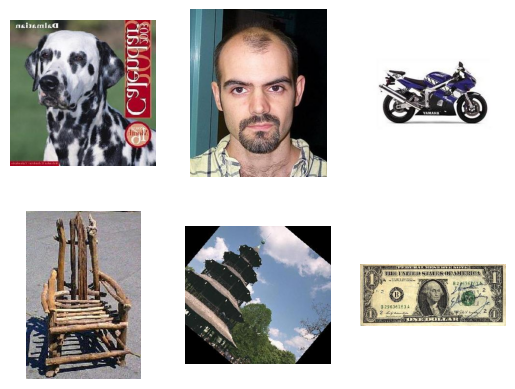

In [5]:
imageExamples = imagePaths[0:6]
visualize(imageExamples, None)

### Image augmentation Example

<Figure size 640x480 with 0 Axes>

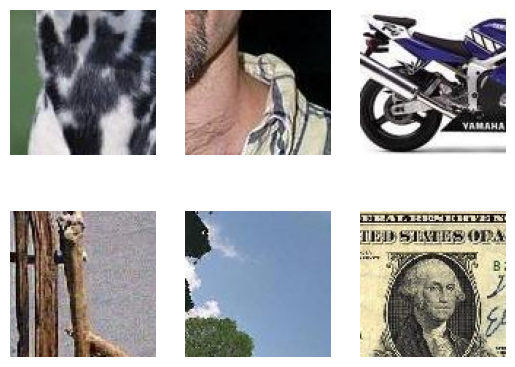

<Figure size 640x480 with 0 Axes>

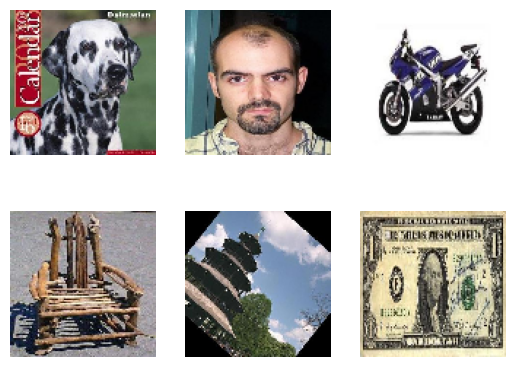

<Figure size 640x480 with 0 Axes>

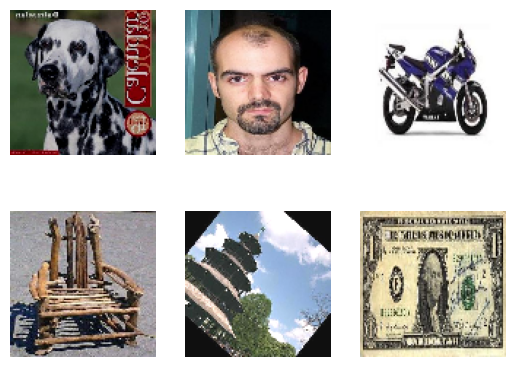

In [6]:
import albumentations as A
image_width, image_height = 100, 100

transformCrop = A.Compose([ A.RandomCrop(width=image_width, height=image_height), ])
transformFlip = A.Compose([ A.HorizontalFlip(p=0.5), ])
transformBrigh = A.Compose([ A.RandomBrightnessContrast(p=0.2),])

visualize(imageExamples, transformCrop)
visualize(imageExamples, transformFlip)
visualize(imageExamples, transformBrigh)

In [15]:
class HDF5DatasetWriter:
    def __init__(self, dims, outputPath, dataKey="images",bufSize=1000):
    # check to see if the output path exists, and if so, raise
    # an exception
        if os.path.exists(outputPath):
            raise ValueError("The supplied ‘outputPath‘ already "
         "exists and cannot be overwritten. Manually delete "
         "the file before continuing.", outputPath)

         # open the HDF5 database for writing and create two datasets:
         # one to store the images/features and another to store the
         # class labels
        self.db = h5py.File(outputPath, "w")
        self.data = self.db.create_dataset(dataKey, dims,dtype="float")
        self.labels = self.db.create_dataset("labels", (dims[0],),dtype="int")

         # store the buffer size, then initialize the buffer itself
         # along with the ind
        self.bufSize = bufSize
        self.buffer = {"data": [], "labels": []}
        self.idx = 0
    def add(self, rows, labels):
        # add the rows and labels to the buffer
        self.buffer["data"].extend(rows)
        self.buffer["labels"].extend(labels)

        # check to see if the buffer needs to be flushed to disk
        if len(self.buffer["data"]) >= self.bufSize:
            self.flush()
    def flush(self):
        # write the buffers to disk then reset the buffer
        i = self.idx + len(self.buffer["data"])
        self.data[self.idx:i] = self.buffer["data"]
        self.labels[self.idx:i] = self.buffer["labels"]
        self.idx = i
        self.buffer = {"data": [], "labels": []}
    def storeClassLabels(self, classLabels):
        # create a dataset to store the actual class label names,
        # then store the class labels
        dt = h5py.special_dtype()
        labelSet = self.db.create_dataset("label_names",
        (len(classLabels),), dtype=dt)
        labelSet[:] = classLabels
    def close(self):
         # check to see if there are any other entries in the buffer
         # that need to be flushed to disk
        if len(self.buffer["data"]) > 0:
            self.flush()

         # close the dataset
        self.db.close()


In [8]:
imagePaths = list(paths.list_images("ImageDataMore"))
random.shuffle(imagePaths)

Class labels encoding and save as json

In [9]:
import json
le = LabelEncoder()

labels = [p.split(os.path.sep)[-2] for p in imagePaths]
labels_encoded = le.fit_transform(labels)

le_name_mapping = dict(zip([int(x) for x in le.transform(le.classes_)], le.classes_))

with open('data/labels.json', 'w') as fp:
    json.dump(le_name_mapping, fp)

le_name_mapping

{0: 'Faces',
 1: 'Faces_easy',
 2: 'Leopards',
 3: 'Motorbikes',
 4: 'accordion',
 5: 'airplanes',
 6: 'anchor',
 7: 'ant',
 8: 'barrel',
 9: 'bass',
 10: 'beaver',
 11: 'binocular',
 12: 'bonsai',
 13: 'brain',
 14: 'brontosaurus',
 15: 'buddha',
 16: 'butterfly',
 17: 'camera',
 18: 'cannon',
 19: 'car_side',
 20: 'ceiling_fan',
 21: 'cellphone',
 22: 'chair',
 23: 'chandelier',
 24: 'cougar_body',
 25: 'cougar_face',
 26: 'crab',
 27: 'crayfish',
 28: 'crocodile',
 29: 'crocodile_head',
 30: 'cup',
 31: 'dalmatian',
 32: 'dollar_bill',
 33: 'dolphin',
 34: 'dragonfly',
 35: 'electric_guitar',
 36: 'elephant',
 37: 'emu',
 38: 'euphonium',
 39: 'ewer',
 40: 'ferry',
 41: 'flamingo',
 42: 'flamingo_head',
 43: 'garfield',
 44: 'gerenuk',
 45: 'gramophone',
 46: 'grand_piano',
 47: 'hawksbill',
 48: 'headphone',
 49: 'hedgehog',
 50: 'helicopter',
 51: 'ibis',
 52: 'inline_skate',
 53: 'joshua_tree',
 54: 'kangaroo',
 55: 'ketch',
 56: 'lamp',
 57: 'laptop',
 58: 'llama',
 59: 'lobster

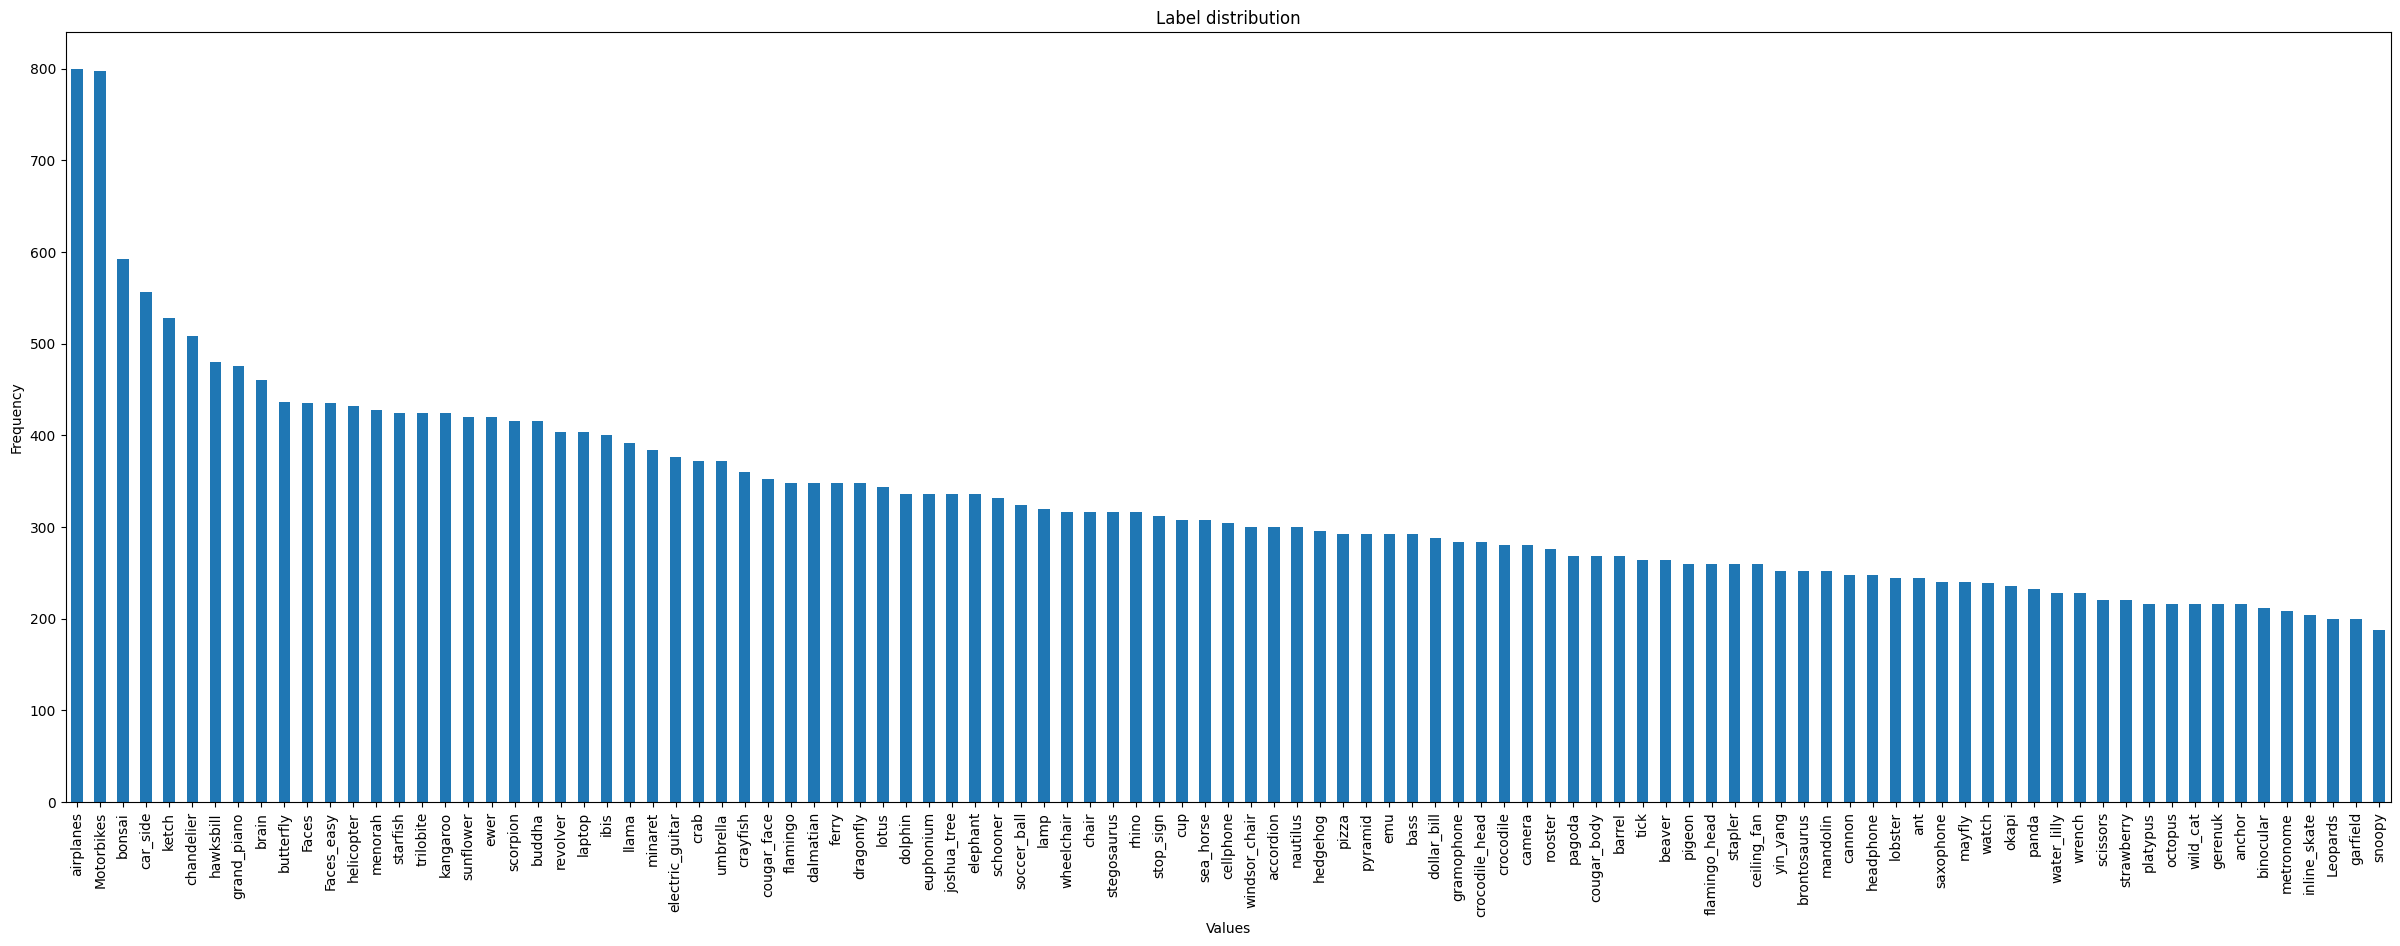

In [10]:
lbDF = pd.DataFrame(labels, columns=['Label'])
value_counts = lbDF['Label'].value_counts()

fig = plt.figure(figsize=(30, 10))

value_counts.plot(kind='bar')

plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Label distribution')
plt.show()

In [11]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

tf.test.is_built_with_cuda()
#tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Num GPUs Available:  1


True

In [12]:
featureModel = VGG16(weights="imagenet", include_top=False, pooling="max")
# Freeze all layers except the last one
featureModel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [16]:
dataset = HDF5DatasetWriter((len(imagePaths), 512 * 1),image_feature_path, dataKey="features")
#dataset.storeClassLabels(le.classes_)

widgets = ["Extracting Features: ", progressbar.Percentage(), " ",
progressbar.Bar(), " ", progressbar.ETA()]
pbar = progressbar.ProgressBar(maxval=len(imagePaths),widgets=widgets).start()

# loop over the images in patches
for i in np.arange(0, len(imagePaths), batch_size):
# extract the batch of images and labels, then initialize the
# list of actual images that will be passed through the network
# for feature extraction
    batchPaths = imagePaths[i:i + batch_size]
    batchLabels = labels_encoded[i:i + batch_size]
    batchImages = []
    # loop over the images and labels in the current batch
    for (j, imagePath) in enumerate(batchPaths):
      # load the input image using the Keras helper utility
      # while ensuring the image is resized to 224x224 pixels
        image = load_img(imagePath, target_size=(224, 224))
        image = img_to_array(image)

        # preprocess the image by (1) expanding the dimensions and
        # (2) subtracting the mean RGB pixel intensity from the
        # ImageNet dataset
        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)

        # add the image to the batch
        batchImages.append(image)
    batchImages = np.vstack(batchImages)
    features = featureModel.predict(batchImages, batch_size=batch_size)
    # reshape the features so that each image is represented by
    # a flattened feature vector of the ‘MaxPooling2D‘ outputs
    features = features.reshape((features.shape[0], 512 * 1))

    # add the features and labels to our HDF5 dataset
    dataset.add(features, batchLabels)
    pbar.update(i)
# close the dataset
dataset.close()
pbar.finish()

1/1 [==============================] - 10s 10s/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 97ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 46ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 53ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 44ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 45ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 31ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 1s 1s/step


Extracting Features: 100% |#####################################| Time: 0:06:09


In [ ]:
# from keras.applications.vgg16 import preprocess_input
# import keras.backend as K
# import numpy as np
# import json
# import shap
#
# # load pre-trained model and choose two images to explain
# model = VGG16(weights='imagenet', include_top=True)
# X,y = shap.datasets.imagenet50()
# to_explain = X[[29,21]]
#
# # load the ImageNet class names
# url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
# fname = shap.datasets.cache(url)
# with open(fname) as f:
#     class_names = json.load(f)
#
# # explain how the input to the 7th layer of the model explains the top two classes
# def map2layer(x, layer):
#     feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
#     return K.get_session().run(model.layers[layer].input, feed_dict)
# e = shap.GradientExplainer(
#     (model.layers[7].input, model.layers[-1].output),
#     map2layer(X, 7),
#     local_smoothing=0 # std dev of smoothing noise
# )
# shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)
# #
# # get the names for the classes
# index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)
#
# # plot the explanations
# shap.image_plot(shap_values, to_explain, index_names)

In [17]:
db = h5py.File(image_feature_path, "r")

df = pd.DataFrame(np.array(db['features']))
df["Labels"] = np.array(db['labels'])

X = pd.DataFrame(np.array(db['features']))
Y = pd.DataFrame(np.array(db['labels']))

df

,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,Labels
0,11.596631,3.534118,87.709541,16.507393,115.548943,60.895668,4.861381,8.418070,60.494030,22.098238,...,23.026842,22.291130,43.390560,54.601364,38.882595,42.173355,47.521175,50.132603,120.468163,10
1,65.548225,8.588998,23.946651,9.268533,17.773365,30.437744,91.742096,72.965538,16.302900,10.203636,...,0.608401,3.576597,11.550836,25.460587,14.669531,35.869339,18.076427,35.116863,8.524241,81
2,16.621252,0.000000,37.175465,0.000000,10.165012,30.501284,60.294308,31.793961,0.000000,0.000000,...,0.000000,71.021286,0.000000,0.000000,0.000000,10.577470,30.407101,26.408052,0.000000,1
3,0.000000,1.095366,23.667936,27.200871,49.776363,49.404076,3.366012,18.212595,42.646328,0.000000,...,11.412951,15.052954,0.000000,14.015597,12.506375,15.802362,0.000000,4.104798,19.985798,51
4,17.083027,20.904747,21.170279,68.507034,120.528198,18.821341,4.878633,53.096889,0.000000,0.000000,...,20.238817,26.194403,20.520403,2.437405,42.358154,50.126938,0.000000,7.539802,14.526567,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33214,38.072136,9.198590,0.000000,71.986679,14.365774,18.485525,2.120681,0.000000,0.000000,37.866089,...,53.114655,0.000000,0.000000,0.000000,14.942225,107.064377,0.000000,33.420933,0.000000,45
33215,48.088875,10.242984,50.869808,26.706041,27.468607,2.462498,11.695442,54.386856,104.142410,12.759030,...,38.146866,2.461884,21.465395,3.509559,22.754538,48.814552,45.424229,15.894562,20.868006,25
33216,25.246119,24.141895,0.000000,6.333586,24.851583,12.246024,63.610764,19.659321,2.222522,27.096743,...,55.404472,26.005087,0.000000,5.640542,3.749726,0.000000,20.624798,2.893831,6.230034,48
33217,36.213459,24.610703,17.709686,0.000000,86.372681,38.657780,8.841885,0.000000,25.648350,0.000000,...,0.000000,16.364292,29.996864,14.607915,6.754644,0.000000,0.000000,20.893990,39.525902,10


In [18]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.6)

x_train

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
32444,57.014114,47.899902,58.548386,0.000000,54.440277,43.358109,57.895859,0.000000,30.825880,40.798344,...,9.882679,61.084618,26.186197,45.274269,56.696312,7.351179,27.922249,4.541735,39.930920,36.186581
10294,0.000000,35.262611,0.000000,64.295502,54.615341,61.610134,62.452351,9.929779,0.000000,0.000000,...,14.554827,83.491928,5.454830,0.000000,0.000000,13.123611,129.733353,0.000000,29.959774,0.000000
4456,11.047713,52.683685,17.521917,25.922438,43.123486,39.636467,2.048881,0.000000,53.875805,9.224442,...,34.492153,24.058702,23.056112,54.641212,18.734604,9.852753,43.243866,0.000000,82.525696,0.564608
25821,0.000000,0.000000,25.033209,7.906887,41.750935,21.891741,115.162025,0.000000,22.133831,41.341957,...,9.329229,58.843941,0.000000,0.000000,76.928772,10.122739,21.734638,0.617588,13.954981,25.868856
9319,0.000000,4.090668,0.000000,0.000000,0.000000,1.090863,56.149654,4.796050,19.269907,0.000000,...,2.053552,26.341742,1.105877,13.059272,0.000000,11.344896,14.408749,0.000000,0.000000,22.645746
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23142,96.916115,28.732782,14.134892,0.000000,29.567347,48.439419,67.346382,4.459745,1.465604,89.630325,...,6.152008,47.748478,0.000000,32.119339,63.002846,31.014212,18.345085,3.859788,7.668289,7.768870
3177,41.280884,5.556727,27.691629,2.830036,32.982029,36.569489,9.269608,27.971523,31.193708,0.000000,...,30.537422,0.000000,25.486021,26.933531,103.344818,25.777338,10.716638,0.623654,16.029028,5.164815
23519,84.986061,56.001236,13.911692,0.000000,56.866165,65.625839,74.140625,33.887810,15.301387,31.242552,...,16.047853,3.347824,118.657806,5.098063,0.000000,83.002693,0.000000,69.002693,10.931363,20.962547
19378,0.000000,1.669320,7.750645,26.091316,24.019289,12.289070,0.000000,0.000000,11.724089,0.000000,...,12.887378,0.000000,7.304996,0.000000,5.796494,9.285196,7.071816,8.476897,2.006423,23.527084


In [62]:
from sklearn.svm import SVC
svmModel = SVC(C=100.0,kernel="poly", verbose=True)

svmModel.fit(x_train, y_train[0].values)

[LibSVM]

SVC(C=100.0, kernel='poly', verbose=True)

Parameters tuning using Gread Search

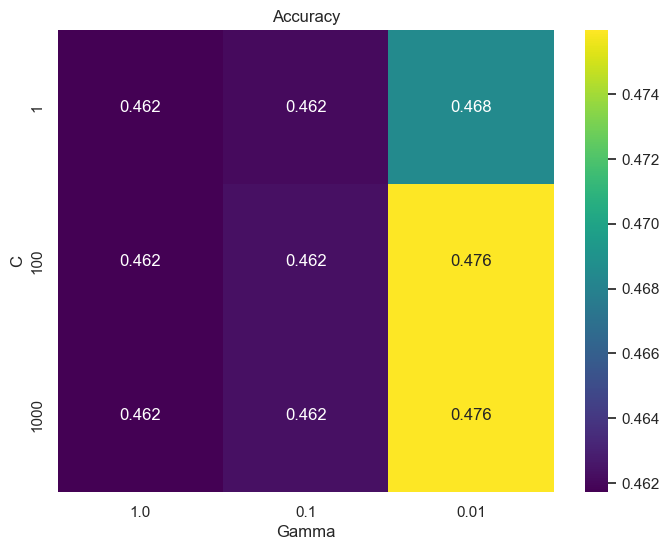

In [65]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Define a range of hyperparameter settings to test
C_range = np.array([1, 100, 1000])
gamma_range = np.array([1, 0.1, 0.01])

# Train an SVM classifier for each hyperparameter setting and record the accuracy
accuracy_scores = np.zeros((len(C_range), len(gamma_range)))
for i, C in enumerate(C_range):
    for j, gamma in enumerate(gamma_range):
        svm = SVC(C=C, gamma=gamma)
        svm.fit(x_train, y_train[0])
        accuracy_scores[i, j] = svm.score(x_test, y_test[0].values)
# Plot the accuracy scores as a heatmap
sns.set()
plt.figure(figsize=(8, 6))
sns.heatmap(accuracy_scores, cmap='viridis', annot=True, fmt='.3f', xticklabels=gamma_range, yticklabels=C_range)
plt.xlabel('Gamma')
plt.ylabel('C')
plt.title('Accuracy')
plt.show()

In [61]:
y_train[0].values

array([36, 46, 65, ..., 91, 51, 54])

Cross validation

In [ ]:
# from sklearn.model_selection import cross_val_score
# cv_scores = cross_val_score(svmModel, x_train, y_train[0], cv=10, scoring='accuracy')
# cv_precision = cross_val_score(svmModel, x_train, y_train[0], cv=10, scoring='precision_weighted' )

In [ ]:
# Plot the distribution of accuracy scores
plt.plot(cv_scores, label="Accuracy")
plt.plot(cv_precision, label="Precision")

plt.xlabel('k-fold')
plt.ylabel('Metrics value')
plt.title('Cross validation')

plt.legend(loc='best')
plt.show()

In [64]:
from sklearn.metrics import accuracy_score
# make predictions on test set
y_pred=svmModel.predict(x_test)

# compute and print accuracy score
print('Model accuracy score with rbf kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_test[0].values, y_pred)))

Model accuracy score with rbf kernel and C=100.0 : 0.9469
Model accuracy score with rbf kernel and C=100.0 : 0.9469


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=le.classes_))

In [ ]:
from sklearn.metrics import precision_score
print('Model precision score C=100.0 : {0:0.4f}'. format(precision_score(y_test, y_pred, average='weighted')))

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

cm = confusion_matrix(y_test, y_pred, labels=np.arange(0, 101))
df_cm = pd.DataFrame(cm, index = [i for i in le.classes_],
                  columns = [i for i in le.classes_])
df_cm.to_excel('classification_report.xlsx')

plt.figure(figsize = (100,100))
sn.heatmap(df_cm, annot=True)
df_cm

,Faces,Faces_easy,Leopards,Motorbikes,accordion,airplanes,anchor,ant,barrel,bass,...,tick,trilobite,umbrella,watch,water_lilly,wheelchair,wild_cat,windsor_chair,wrench,yin_yang
Faces,255,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Faces_easy,4,253,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Leopards,0,0,120,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
Motorbikes,0,0,0,473,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
accordion,0,0,0,0,186,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wheelchair,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,182,0,0,0,0
wild_cat,0,0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,115,0,0,0
windsor_chair,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,181,0,0
wrench,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,117,0


In [ ]:
image = load_img("test-images\img_1.png", target_size=(224, 224))
image = img_to_array(image)

# preprocess the image by (1) expanding the dimensions and
# (2) subtracting the mean RGB pixel intensity from the
# ImageNet dataset
image = np.expand_dims(image, axis=0)
image = imagenet_utils.preprocess_input(image)

features = featureModel.predict([image], batch_size=1)
features = features.reshape((features.shape[0], 512 * 1))
features

In [ ]:
pred = svmModel.predict(features)
pred

In [ ]:
le_name_mapping[pred[0]]

In [ ]:
from sklearn.manifold import TSNE
tsne_obj = TSNE(
    n_components=2,
    init='pca',
    random_state=101,
    method='barnes_hut',
    n_iter=500,
    verbose=2
)
tsne_features = tsne_obj.fit_transform(x_test)

In [ ]:
obj_categories = le.classes_
colors = plt.cm.rainbow(np.linspace(0, 1, 100))
fig = plt.figure(figsize=(100, 100))
#ax = fig.add_subplot(111, projection='3d')

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
    plt.scatter(
        tsne_features[np.where(y_test == c_group), 0],
        tsne_features[np.where(y_test == c_group), 1],
        #tsne_features[np.where(y_test == c_group), 2],
        marker='o',
        color=c_color,
        linewidth=20,
        alpha=0.8,
        label=c_label
    )
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
#ax.set_zlabel('Dimension 3')
plt.title('t-SNE on Testing Samples')
#plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)

In [ ]:
# width = 4000
# height = 3000
# max_dim = 100
#
# full_image = Image.new('RGBA', (width, height))
# for img, x, y in zip(images, tx, ty):
#     tile = Image.open(img)
#     rs = max(1, tile.width/max_dim, tile.height/max_dim)
#     tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
#     full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))
#
# matplotlib.pyplot.figure(figsize = (16,12))
# imshow(full_image)